In [1]:
from qiskit import *
from math import log2, ceil, pi

In [2]:
def cria_tabela_saida_sintese_nova(n_bits, A, N):
    saida = []
    for i in range(2**n_bits):
        v = A*i % N
        saida.append(v)

    return saida

print(cria_tabela_saida_sintese_nova(4, 2, 15))

[0, 2, 4, 6, 8, 10, 12, 14, 1, 3, 5, 7, 9, 11, 13, 0]


In [3]:
def porta(k, x, y, pi, limite):
    """
    Realiza uma troca na permutação baseada em uma "porta" e imprime a operação.

    Args:
        k (int): Número de bits.
        x (int): Valor atual na permutação a ser trocado.
        y (int): Posição do bit (1-based) que define a porta.
        pi (list): A lista (vetor) da permutação.
        limite (int): O deslocamento para limitar a busca inicial no array.
    """
    # Calcula o valor a ser trocado (aux) usando XOR para inverter o bit na posição y.
    # y-1 porque a indexação de bits é 0-based na programação, mas 1-based na lógica do problema.
    z = 1 << (y - 1)
    aux = x ^ z

    # --- Imprime a representação da porta, como "T(1*0)" ---
    # Constrói uma lista de caracteres para a representação binária
    representacao_porta = []
    for i in range(k - 1, -1, -1):
        if i == y - 1:
            representacao_porta.append('*')
        elif (x & (1 << i)):
            representacao_porta.append('1')
        else:
            representacao_porta.append('0')
            
    #print(f"T({''.join(representacao_porta)[::-1]})")

    # --- Realiza a troca na permutação ---
    # Encontra o índice de 'aux' na parte "não resolvida" da lista e o substitui por 'x'.
    # O slice pi[:-limite] corresponde à busca nos primeiros pow(2,k)-limite elementos.
    # Nota: Em Python, é mais fácil usar o método index().
    block_index = -1
    try:
        # Busca apenas na parte relevante da lista, que diminui a cada iteração do hipercubo
        if limite > 0:
            block_index = pi.index(aux, 0, len(pi) - limite)
        else:
            block_index = pi.index(aux)
        pi[block_index] = x
    except ValueError:
        # Ocorre se o valor não for encontrado. O código C original não trata este erro.
        # print(f"Aviso: valor {aux} não encontrado na sublista designada.")
        return

    # Encontra o índice de 'x' (que não seja o que acabamos de colocar) e o substitui por 'aux'.
    # Isso completa a troca.
    try:
        for i in range(len(pi)):
            if pi[i] == x and i != block_index:
                pi[i] = aux
                break
    except ValueError:
        pass # Ignora se não encontrar

    return f"{''.join(representacao_porta)}"[::-1]

def hipercubo(k, vet_s):
    """
    Processa a permutação para ordená-la, imprimindo as portas necessárias.

    Args:
        k (int): Número de bits.
        vet_s (list): O vetor da permutação.
    """
    n = 1 << k  # 2^k, a quantidade total de valores
    limite = -1
    cont = 0
    listaPortas = []

    # Itera de N-1 para 0, tentando colocar cada valor i na sua posição correta vet_s[i]
    for i in range(n - 1, -1, -1):
        limite += 1
        x = i
        
        # Se o valor na posição 'i' já não for o correto
        if vet_s[i] != x:
            # z contém os bits que precisam ser invertidos para transformar vet_s[i] em x
            z = x ^ vet_s[i]
            
            # Para cada bit que precisa ser mudado, aplica uma porta
            for j in range(k):
                # Verifica se o j-ésimo bit está setado em z
                if (z & (1 << j)) > 0:
                    listaPortas.append(porta(k, vet_s[i], j + 1, vet_s, limite))
                    cont += 1
    
    #print(f"\n{cont} iterações (portas)")

    return listaPortas[::-1]

def cria_portas_sintese_nova(n_bits, A, N):
    saida = cria_tabela_saida_sintese_nova(n_bits, A, N)

    portas = hipercubo(n_bits, saida)

    return portas

def cria_circuito_sintese_nova(n_bits, A, N, controlado=False):
    portas = cria_portas_sintese_nova(n_bits, A, N)

    q_reg = QuantumRegister(n_bits, "qreg")

    qc = QuantumCircuit(q_reg)
    
    for porta in portas:
        ctrl_state = ""
        if porta:
            for bit in range(len(porta)):

                if porta[bit] == "*":
                    targetidx = bit

                else:
                    ctrl_state = porta[bit] + ctrl_state

            qc.mcx(control_qubits=q_reg[0:targetidx]+q_reg[targetidx+1:], target_qubit=q_reg[targetidx], ctrl_state=ctrl_state)

    return qc.to_gate()

#hipercubo(3, [0,1,2,3,4,7,5,6])
# print(cria_portas_sintese_nova(4, 2, 15))

# cria_circuito_sintese_nova(5,4,21).draw("mpl")s

In [4]:
def simbolo_de_jacobi(a, n):
    """
    a = numerador
    n = denominador
    """

    a %= n
    t = 1
    while a != 0:
        while a % 2 == 0:
            a /= 2
            r = n % 8
            if r == 3 or r == 5:
                t = -t
        a, n = n, a
        if a % 4 == 3 and n % 4 == 3:
            t = -t
        a %= n
    if n == 1:
        return t
    else:
        return 0


In [5]:
"""Valores:
    b*A^x mod N : x é o valor em superposição
    b é inicializado como 1.
    O valor da variável x_bits corresponde ao tamanho da amostra (2**x_bits).
"""

N = 15  # N = p*q; p, q primos
n_bits = int(log2(N))+1

bases = []
for i in range(1000):
    if simbolo_de_jacobi(i, N) == -1:
        bases.append(i)
print(bases)
A = bases[0] # Base do expoente

b = 1 # Registrador inicial da multiplicação

x_bits = 2*n_bits # q=2**x_bits, tamanho da amostra, idealmente é 2n_bits

reg_x = QuantumRegister(1, "x")
#number_x = QuantumCircuit(reg_x)

reg_b = QuantumRegister(n_bits, "b")

# Registradores Ancillas
reg_0 = QuantumRegister(n_bits, "0")


reg_result = ClassicalRegister(x_bits, "resultado")


#x_bits + 2*n_bits + 3
qc = QuantumCircuit(reg_x, reg_b, reg_result)

qc.x(reg_b[0])

for i in range(x_bits-1,-1,-1):
    
    qc.h(reg_x[0])
    print((A**(2**(i))) % N)
    qc.append(cria_circuito_sintese_nova(n_bits, (A**(2**(i))) % N, N, controlado=True).control(1), reg_x[:] + reg_b[:])
    # print("Tabela Saída: ", n_bits, (A**(2**(i))) % N, N, cria_tabela_saida(n_bits, (A**(2**(i))) % N, N))

    # a_inv = mod_inverse(A**(2**i), N)

    # qc.append(cria_circuito_sintese_nova(n_bits, a_inv, N, controlado=True).inverse(), reg_x[:] + reg_0[:] + reg_b[:])
    # print("Tabela Saída: ", n_bits, a_inv, N, cria_tabela_saida(n_bits, a_inv, N))

    # for j in range(n_bits):
    #     qc.cswap(reg_x[0], reg_b[j], reg_0[j])

    for j in range(x_bits-1,i,-1):
        with qc.if_test((reg_result[x_bits-1-j],1)) as else_:
            qc.p((-pi/(2**(j-(i)))), reg_x[0])
    qc.h(reg_x[0])
    qc.measure(reg_x[0], reg_result[x_bits-1-i])
    qc.reset(reg_x[0])


[7, 11, 13, 14, 22, 26, 28, 29, 37, 41, 43, 44, 52, 56, 58, 59, 67, 71, 73, 74, 82, 86, 88, 89, 97, 101, 103, 104, 112, 116, 118, 119, 127, 131, 133, 134, 142, 146, 148, 149, 157, 161, 163, 164, 172, 176, 178, 179, 187, 191, 193, 194, 202, 206, 208, 209, 217, 221, 223, 224, 232, 236, 238, 239, 247, 251, 253, 254, 262, 266, 268, 269, 277, 281, 283, 284, 292, 296, 298, 299, 307, 311, 313, 314, 322, 326, 328, 329, 337, 341, 343, 344, 352, 356, 358, 359, 367, 371, 373, 374, 382, 386, 388, 389, 397, 401, 403, 404, 412, 416, 418, 419, 427, 431, 433, 434, 442, 446, 448, 449, 457, 461, 463, 464, 472, 476, 478, 479, 487, 491, 493, 494, 502, 506, 508, 509, 517, 521, 523, 524, 532, 536, 538, 539, 547, 551, 553, 554, 562, 566, 568, 569, 577, 581, 583, 584, 592, 596, 598, 599, 607, 611, 613, 614, 622, 626, 628, 629, 637, 641, 643, 644, 652, 656, 658, 659, 667, 671, 673, 674, 682, 686, 688, 689, 697, 701, 703, 704, 712, 716, 718, 719, 727, 731, 733, 734, 742, 746, 748, 749, 757, 761, 763, 764, 772, 

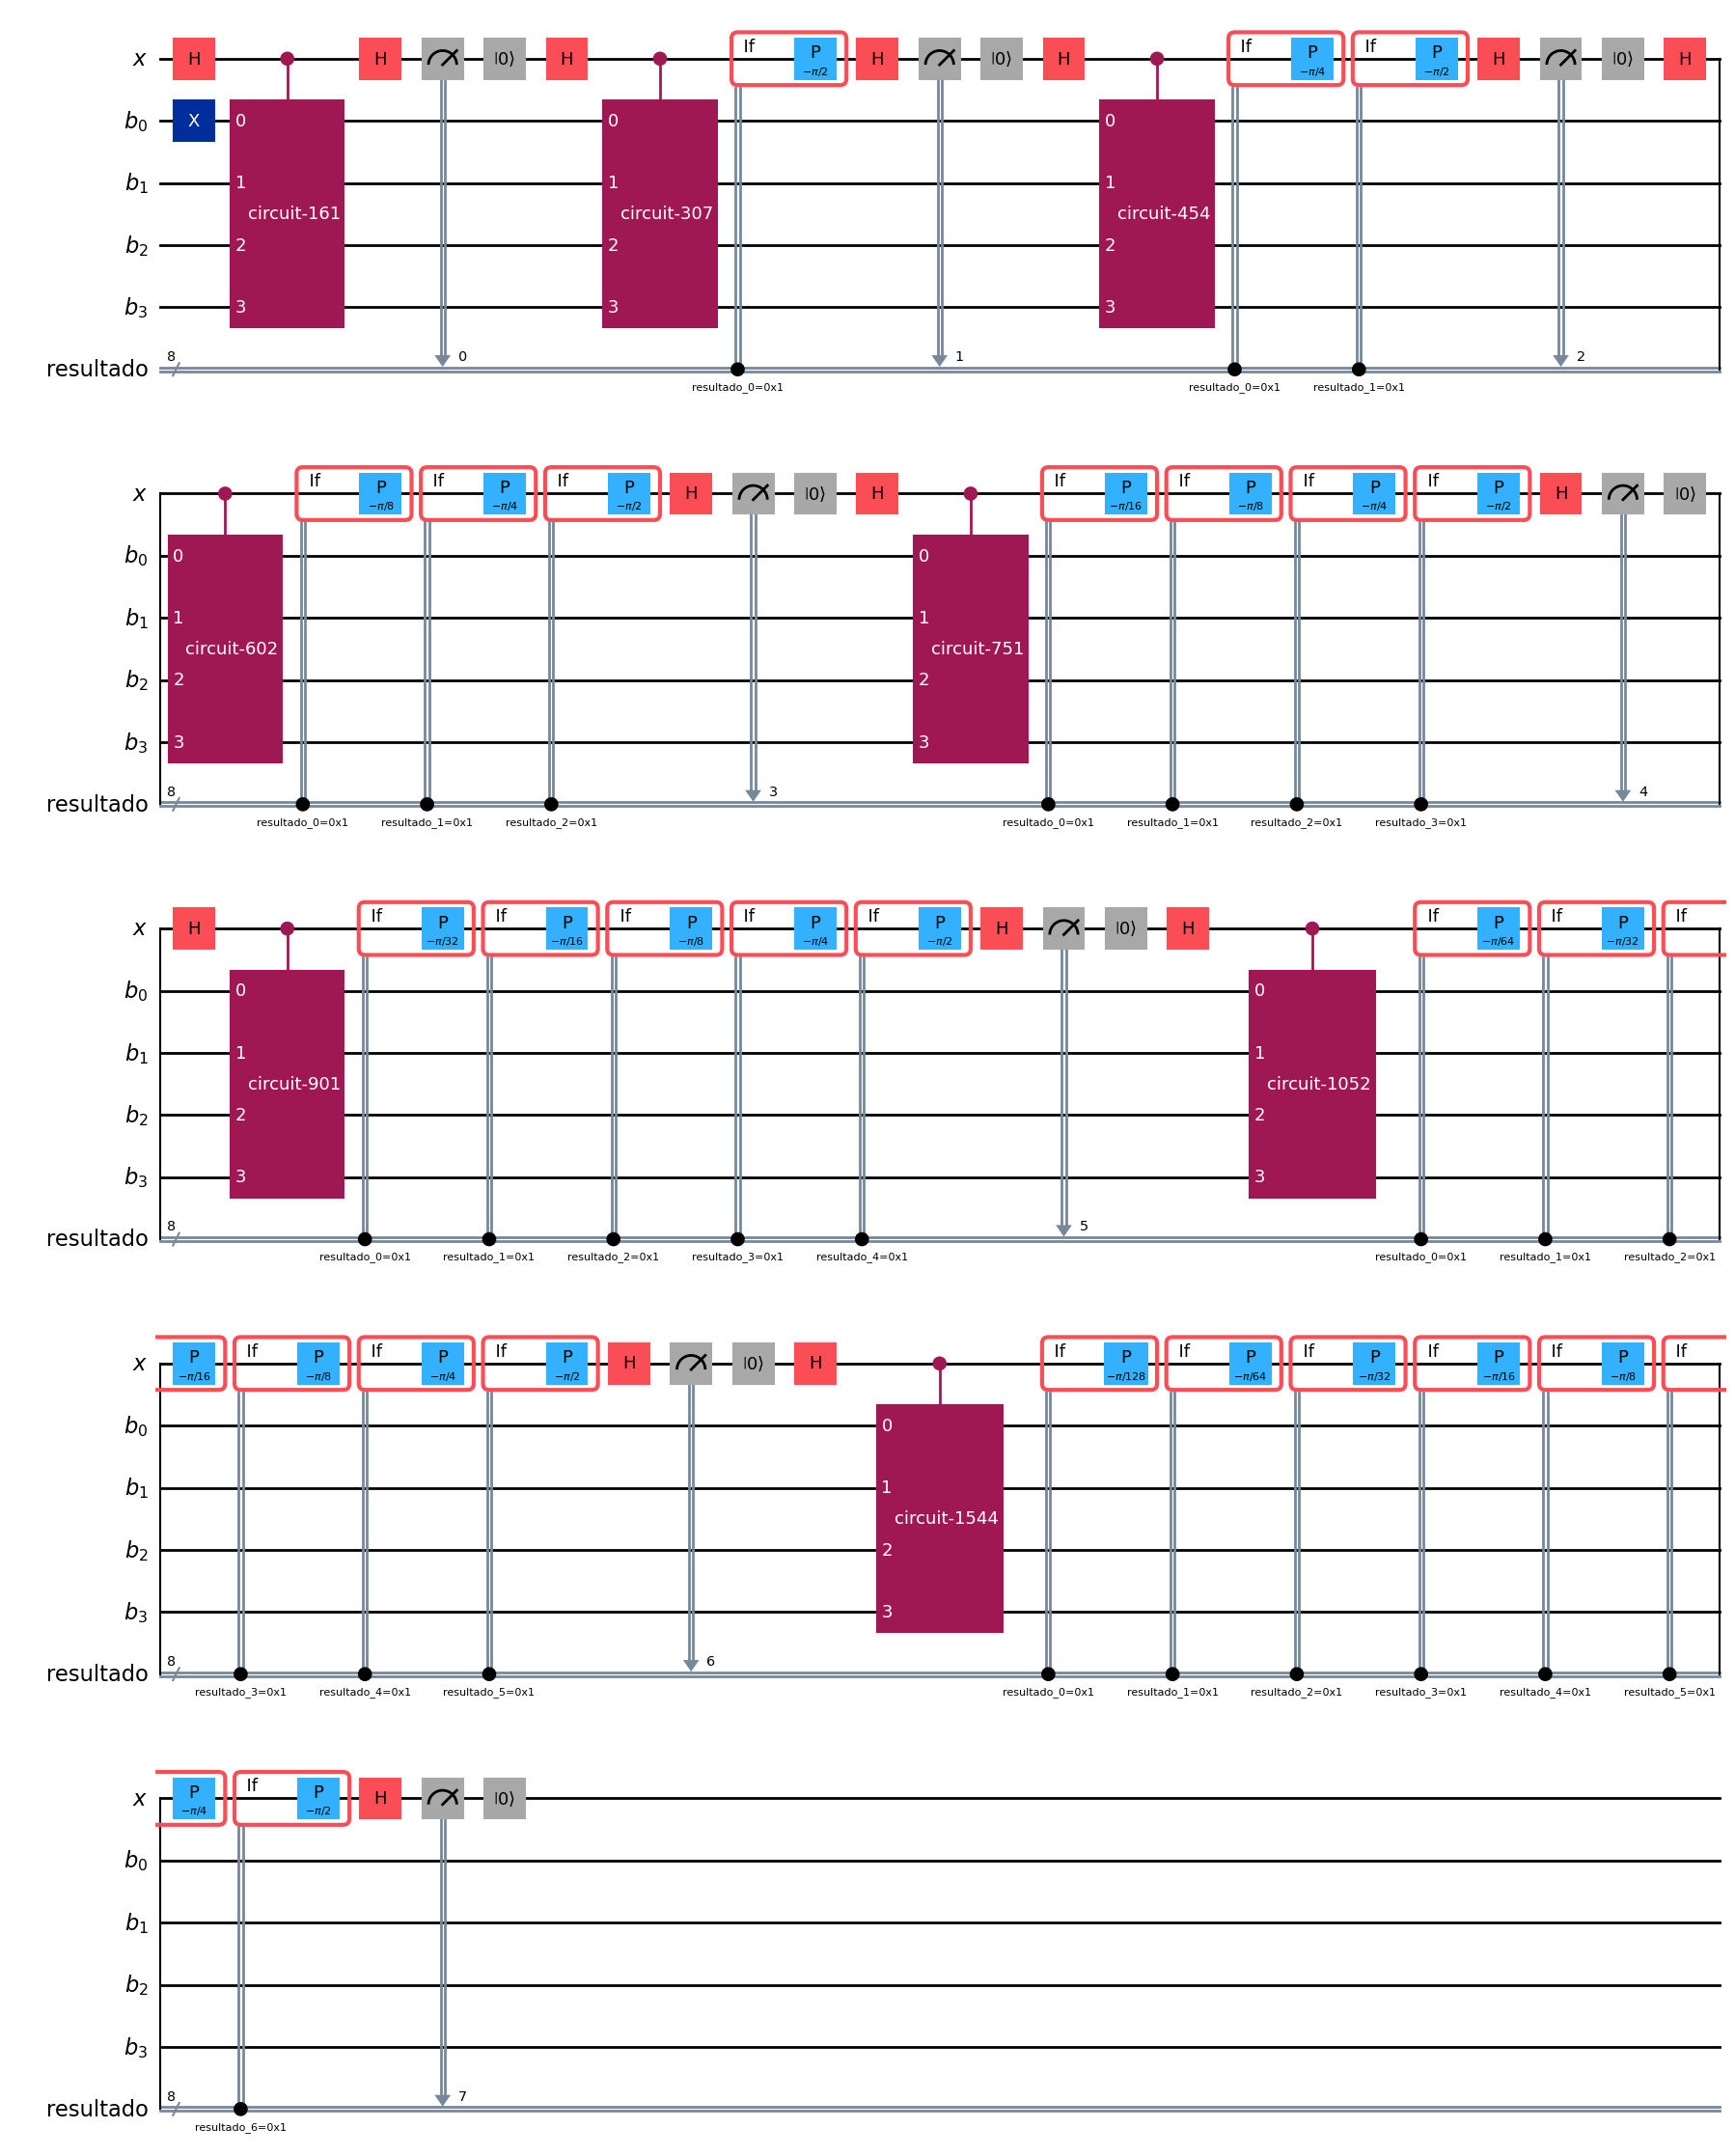

In [6]:
qc.draw("mpl")


In [7]:
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler

backend1 = AerSimulator()
qc1 = transpile(qc, backend=backend1)

sampler = Sampler(backend1)
job = sampler.run([qc1], shots=1024)
print("b=" + str(b), "A=" + str(A), "N=" + str(N))

counts = job.result()[0].data.resultado.get_int_counts()

print(counts)


b=1 A=7 N=15
{128: 268, 0: 253, 192: 257, 64: 246}


In [8]:
Resultado = job.result()[0].data.resultado.get_int_counts()

for i in range(1<<(x_bits)):
  if i not in Resultado:
    Resultado[i] = 0

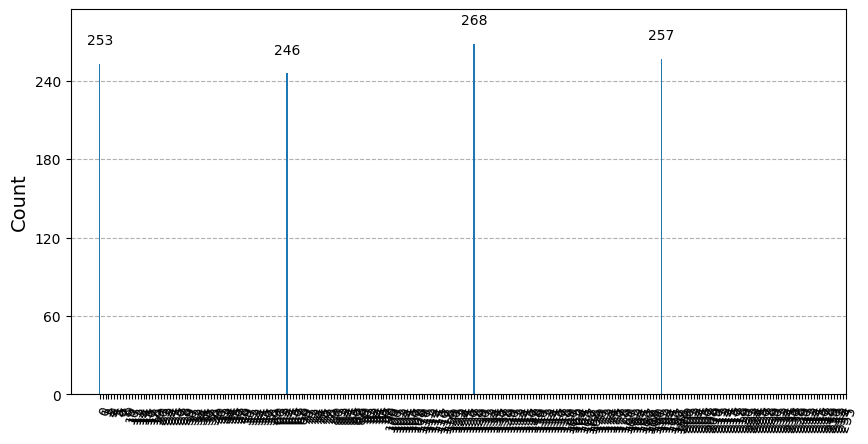

In [9]:
from qiskit.visualization import plot_histogram

plot_histogram(Resultado, figsize=[10,5])